**References:** 

1. [DEAP: A Database for Emotion Analysis using Physiological Signals](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/doc/tac_special_issue_2011.pdf)

2. [Online Prediction of Driver Distraction Based on Brain Activity Patterns](https://www.researchgate.net/publication/267154789_Online_Prediction_of_Driver_Distraction_Based_on_Brain_Activity_Patterns)

3. [Emotion Recognition with Machine Learning Using EEG Signals](https://arxiv.org/pdf/1903.07272.pdf)

4. [EEG Correlates of Different Emotional States Elicited during Watching Music Videos](https://www.researchgate.net/publication/221622214_EEG_Correlates_of_Different_Emotional_States_Elicited_during_Watching_Music_Videos)

5. [The Effect of Transcranial Magnetic Stimulation on Brain Electrical Activity](https://www.researchgate.net/publication/267811728_THE_EFFECT_OF_TRANSCRANIAL_MAGNETIC_STIMULATION_ON_BRAIN_BIOELECTRICAL_ACTIVITY)

**Original dataset:** 

The dataset is mounted from our Google Drive and could be downloaded [here](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/download.html). 

In [1]:
import os
import time
import pickle
import pandas as pd
import numpy as np

In [2]:
from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

#!pip install scikit-learn==0.20.3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

#!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

#!pip install fooof
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

/var/folders/w_/4l7k3gwn3g581ztmz26mzdc00000gn/T/ipykernel_3708/1374096748.py:26: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


# Load dataset
The EEG and peripheral physiological signals of 32 participants were recorded as each watched 40 music videos. Participants rated each video in terms of the levels of arousal, valence, dominance, and liking. The data was downsampled (to 128Hz), preprocessed and segmented in pickled Python formats.

In [3]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [4]:
# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 23): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)

Each participant file contains two arrays: a "data" array (40 trials x 40 channels x 8064 data) and a "label" array (40 trials x 4 subjective ratings: valence, arousal, dominance, liking). We combine the data files into 2 new arrays with 880 trials for 22/32 participants (participants with frontal videos recorded).

In [36]:
# 22x40 = 880 trials for 22 participants
labels = []
data = []

for i in files: 
  filename = "./eeg_data/s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  print(len(trial['data'][0][0]))
  labels.append(trial['labels'])
  data.append(trial['data'])

# Re-shape arrays into desired shapes
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(880, 4)

8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064
8064


In [32]:
print(2222)
print(len(data[0]))
print(len(data))
print(len(data[0][0]))
print(len(data[0][0][0]))
# Labels.shape:  (880, 4)
# Data.shape:  (880, 40, 8064)

2222
40
22
40
8064


In [33]:
data = np.array(data)
print(data.shape)
data = data.flatten()
print(data.shape)
data = data.reshape(880, 40, 8064)
print(2222)
print(len(data[0]))
print(len(data))
print(len(data[0][0]))
print(data.shape)


(22, 40, 40, 8064)
(283852800,)
2222
40
880
8064
(880, 40, 8064)


# Explore and pre-process data

## Labels

#### Get Valence and Arousal ratings
Valence describes the extent to which an emotion is positive or negative, whereas Arousal refers to its intensity, i.e., the strength of the associated emotional state.

In [108]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

          Valence     Arousal
count  880.000000  880.000000
mean     5.218034    5.238898
std      2.093837    1.879631
min      1.000000    1.000000
25%      3.650000    3.895000
50%      5.040000    5.490000
75%      7.040000    6.795000
max      9.000000    9.000000


In [7]:
print(df_label_ratings.head(15))

    Valence  Arousal
0      7.71     7.60
1      8.10     7.31
2      8.58     7.54
3      4.94     6.01
4      6.96     3.92
5      8.27     3.92
6      7.44     3.73
7      7.32     2.55
8      4.04     3.29
9      1.99     4.86
10     2.99     2.36
11     2.71     2.77
12     1.95     3.12
13     4.18     2.24
14     3.17     8.08


<Axes: >

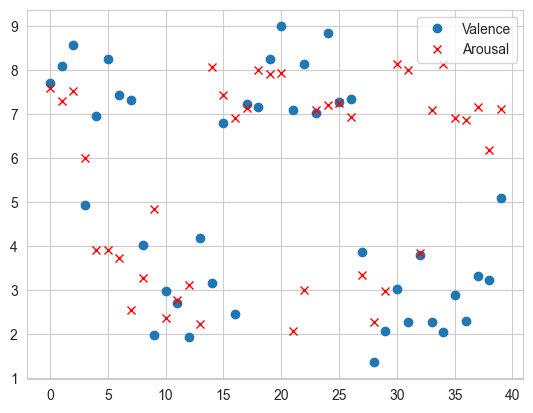

In [8]:
# Plot the first 40 data rows (first participant)
df_label_ratings.iloc[0:40].plot(style=['o','rx'])

#### Check positive/negative cases

The combinations of Valence and Arousal can be converted to emotional states: High Arousal Positive Valence (Excited, Happy), Low Arousal Positive Valence (Calm, Relaxed), High Arousal Negative Valence (Angry, Nervous), and Low Arousal Negative Valence (Sad, Bored).

In [9]:
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [10]:
# Check nummber of trials per each group
print("Positive Valence:", str(len(df_hahv) + len(df_lahv)))
print("Negative Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

Positive Valence: 457
Negative Valence: 423
High Arousal: 442
Low Arousal: 438


In [11]:
# Check nummber of trials per each group
print("High Arousal Positive Valence:", str(len(df_hahv)))
print("Low Arousal Positive Valence:", str(len(df_lahv)))
print("High Arousal Negative Valence:", str(len(df_halv)))
print("Low Arousal Negative Valence:", str(len(df_lalv)))

High Arousal Positive Valence: 242
Low Arousal Positive Valence: 215
High Arousal Negative Valence: 200
Low Arousal Negative Valence: 223


In [12]:
# Get mean and std of each group
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['Valence'].mean(),2), "STD", np.round(df_hahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['Arousal'].mean(),2), "STD", np.round(df_hahv['Arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['Valence'].mean(),2), "STD", np.round(df_lahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['Arousal'].mean(),2), "STD", np.round(df_lahv['Arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['Valence'].mean(),2), "STD", np.round(df_halv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['Arousal'].mean(),2), "STD", np.round(df_halv['Arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['Valence'].mean(),2), "STD", np.round(df_lalv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['Arousal'].mean(),2), "STD", np.round(df_lalv['Arousal'].std(),2))

HAHV
Valence: Mean 7.12 STD 1.04
Arousal: Mean 6.81 STD 0.84

LAHV:
Valence: Mean 6.67 STD 1.09
Arousal: Mean 3.87 STD 1.09

HALV:
Valence: Mean 3.19 STD 1.23
Arousal: Mean 6.79 STD 0.96

LALV:
Valence: Mean 3.57 STD 1.12
Arousal: Mean 3.47 STD 1.19


{'whiskers': [<matplotlib.lines.Line2D at 0x143103100>,
 'caps': [<matplotlib.lines.Line2D at 0x143103640>,
 'boxes': [<matplotlib.lines.Line2D at 0x143102e60>,
 'medians': [<matplotlib.lines.Line2D at 0x143103b80>,
 'fliers': [<matplotlib.lines.Line2D at 0x143103e20>,
 'means': []}

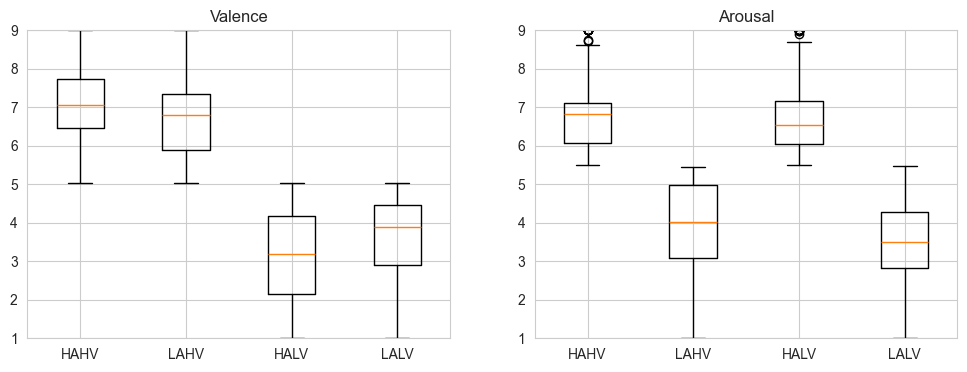

In [13]:
# Valence and Arousal ratings between groups
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title("Valence")
axs[0].set_ylim(1, 9)
axs[0].boxplot([df_hahv['Valence'], df_lahv['Valence'], df_halv['Valence'], df_lalv['Valence']], labels=['HAHV','LAHV','HALV', 'LALV'])

axs[1].set_title("Arousal")
axs[1].set_ylim(1, 9)
axs[1].boxplot([df_hahv['Arousal'], df_lahv['Arousal'], df_halv['Arousal'], df_lalv['Arousal']], labels=['HAHV','LAHV','HALV', 'LALV'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1433f6cb0>,
 'caps': [<matplotlib.lines.Line2D at 0x1433f71f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1433f6a10>,
 'medians': [<matplotlib.lines.Line2D at 0x1433f7730>,
 'fliers': [<matplotlib.lines.Line2D at 0x1433f79d0>,
 'means': []}

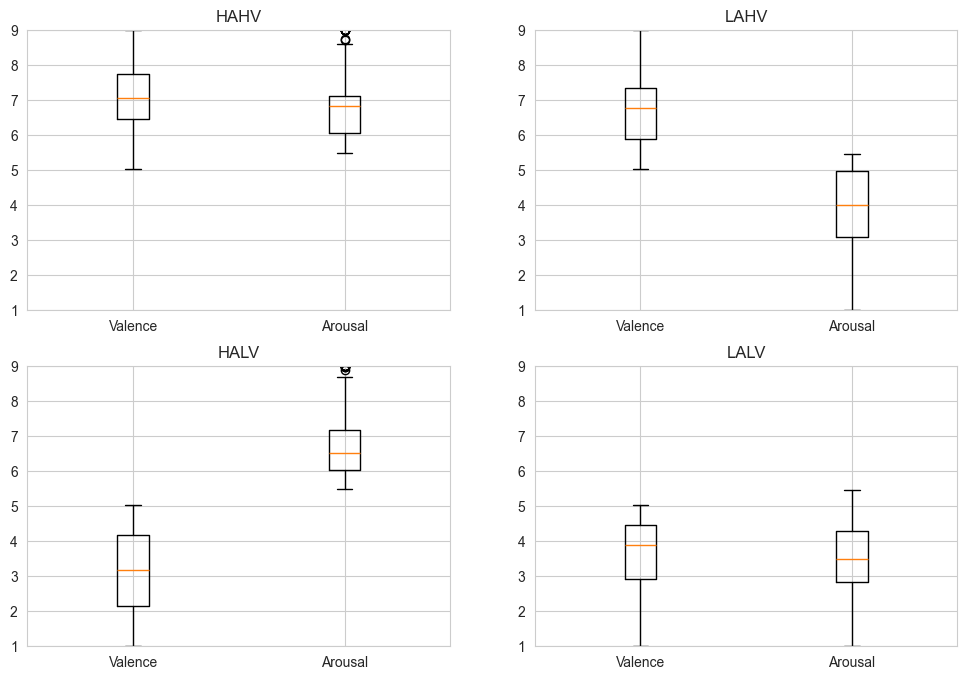

In [14]:
# Valence and Arousal ratings per group
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].set_title("HAHV")
axs[0,0].set_ylim(1, 9)
axs[0,0].boxplot([df_hahv['Valence'], df_hahv['Arousal']], labels=['Valence','Arousal'])

axs[0,1].set_title("LAHV")
axs[0,1].set_ylim(1, 9)
axs[0,1].boxplot([df_lahv['Valence'], df_lahv['Arousal']], labels=['Valence','Arousal'])

axs[1,0].set_title("HALV")
axs[1,0].set_ylim(1, 9)
axs[1,0].boxplot([df_halv['Valence'], df_halv['Arousal']], labels=['Valence','Arousal'])

axs[1,1].set_title("LALV")
axs[1,1].set_ylim(1, 9)
axs[1,1].boxplot([df_lalv['Valence'], df_lalv['Arousal']], labels=['Valence','Arousal'])

#### One hot encoding

In [15]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0 
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [16]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
  labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (880, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["Positive Valence", "High Arousal"])
print(df_labels.describe())

       Positive Valence  High Arousal
count        880.000000    880.000000
mean           0.519318      0.502273
std            0.499911      0.500279
min            0.000000      0.000000
25%            0.000000      0.000000
50%            1.000000      1.000000
75%            1.000000      1.000000
max            1.000000      1.000000


In [17]:
# Dataset with only Valence column
df_valence = df_labels['Positive Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

## EEG data

### Separate EEG and non-EEG data

The dataset includes 32 EEG channels and 8 peripheral physiological channels. The peripheral signals include: electrooculogram (EOG), electromyograms (EMG) of Zygomaticus and Trapezius muscles, GSR, respiration amplitude, blood volume by plethysmograph, skin temperature.

In [18]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])

In [19]:
eeg_data = []
print(len(data))
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(880, 32, 8064)


### Welch's feature extraction

For the EEG data, we use Welch's method to extract theta, alpha, beta, and gamma spectral
power for each electrode. The frequency bands used:
theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz),
and gamma (30 - 64 Hz).

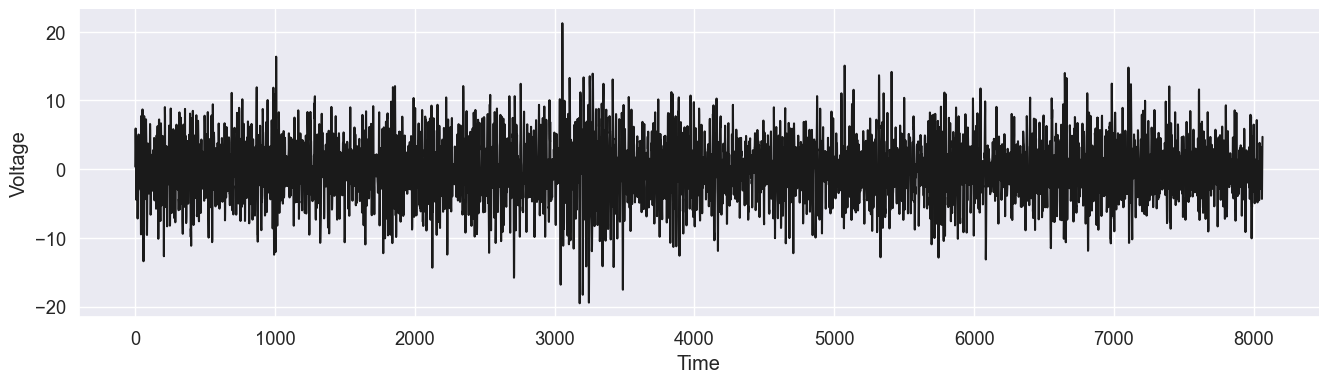

In [20]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

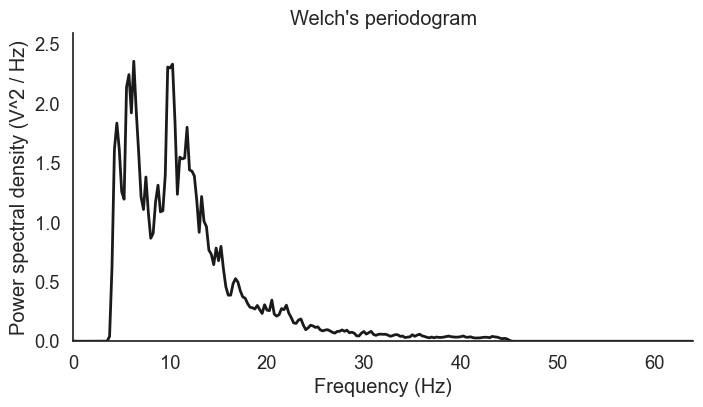

In [21]:
# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(eeg_data[0,31], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

#### Theta band power

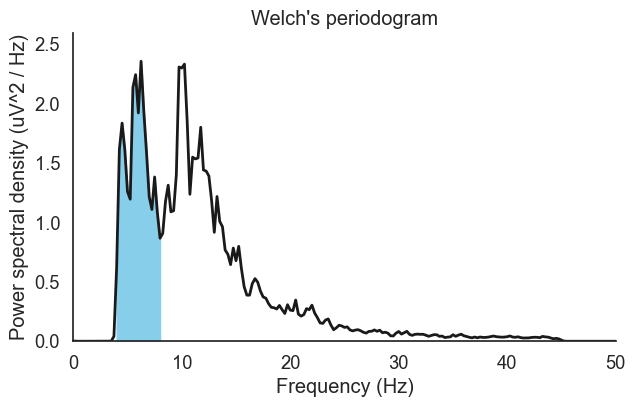

In [22]:
# Define theta lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Alpha band power

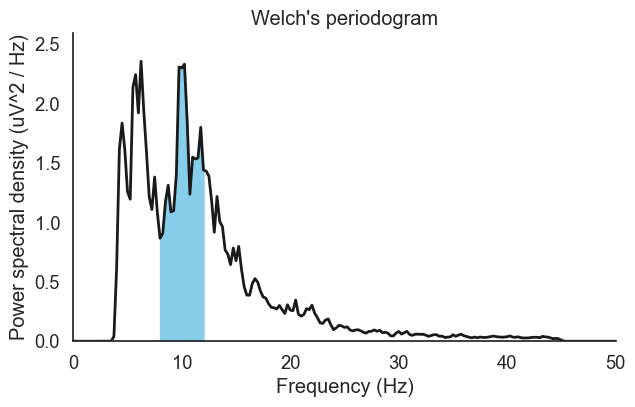

In [23]:
# Define alpha lower and upper limits
low, high = 8, 12

# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the alpha area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_alpha, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Beta band power

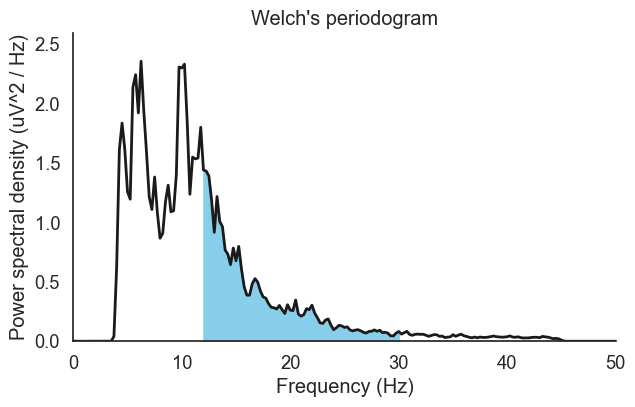

In [24]:
# Define beta lower and upper limits
low, high = 12, 30

# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the beta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_beta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Gamma band power

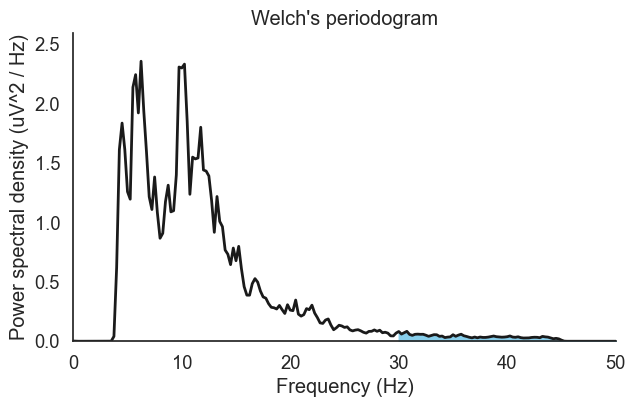

In [25]:
# Define delta lower and upper limits
low, high = 30, 64

# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the gamma area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_gamma, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Functions to get band power values

In [26]:
"""Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [27]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if band == "theta": # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif band == "alpha": # reflection, relaxation
    bd = (8,12)
  elif band == "beta": # concentration, problem solving, memory
    bd = (12,30)
  elif band == "gamma": # cognition, perception, learning, multi-tasking
    bd = (30,64)
  
  return bandpower(eeg_data[trial,channel], 128, bd)

print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295193
6.286556266834863
0.9879159580139809


### Create EEG plots

#### General plots

In [28]:
info = mne.create_info(32, sfreq=128)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [29]:
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [30]:
raw_data = mne.io.RawArray(eeg_data[31], info)

Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


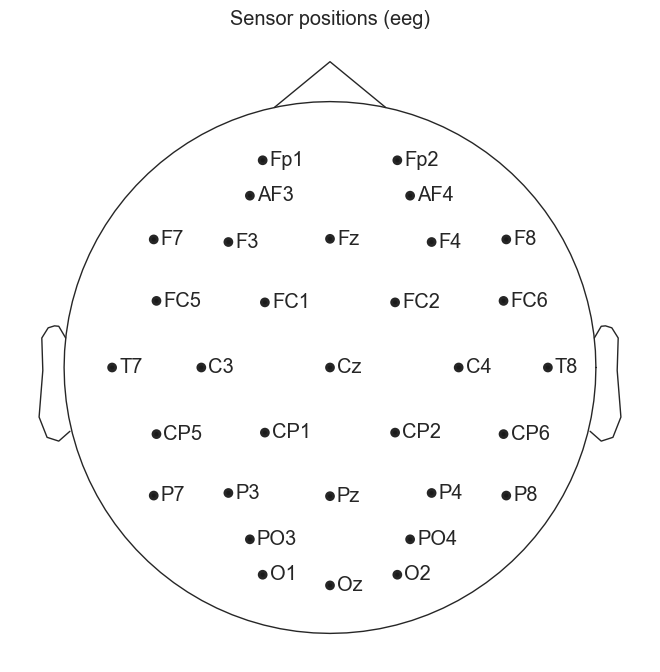

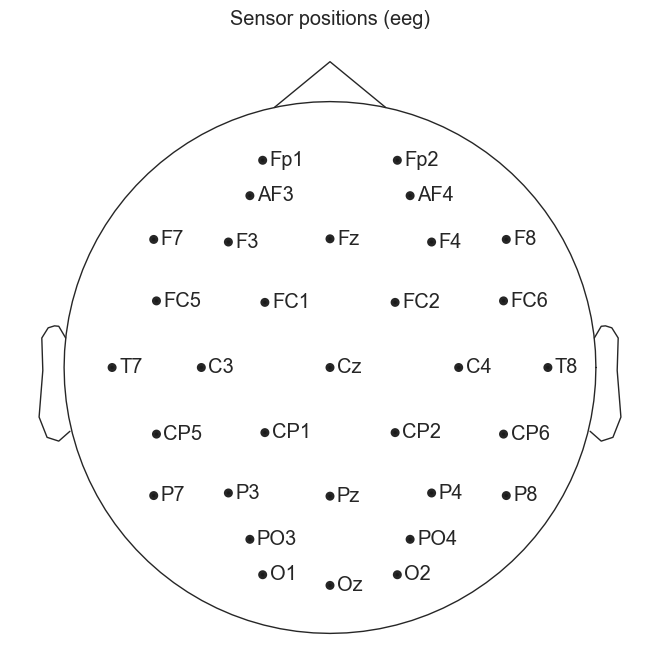

In [31]:
# Plot sensor positions
montage = mne.channels.make_standard_montage("biosemi32")
raw_data.set_montage(montage)
montage.plot()

Effective window size : 16.000 (s)


TypeError: SpanSelector.__init__() got an unexpected keyword argument 'rectprops'

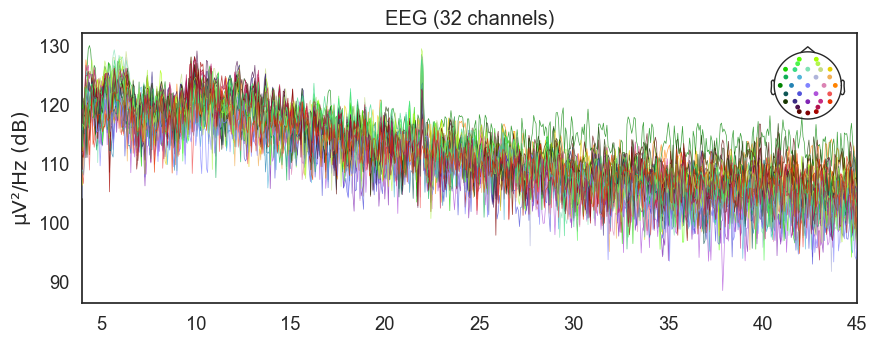

In [32]:
# Plot the power spectral density across channels
mne.viz.plot_raw_psd(raw_data, fmin = 4, fmax= 45)

#### Topomaps for each band of frequencies

Following this thread: https://mail.nmr.mgh.harvard.edu/pipermail//mne_analysis/2019-April/005812.html

In [ ]:
# Theta band, first trial
evData_th = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_th.filter(4, 8) 
evData_th.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

In [ ]:
# Alpha band, first trial
evData_al = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_al.filter(8, 12) 
evData_al.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

In [ ]:
# Beta band, first trial
evData_bt = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_bt.filter(12, 30) 
evData_bt.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

In [ ]:
# Gamma band, first trial
evData_gm = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_gm.filter(30, 63.9) 
evData_gm.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

#### Topomaps of subjects from HAHV - HALV - LAHV - LALV groups

In [37]:
# Getting samples from 4 label groups, same subject
ev_data_hahv = mne.EvokedArray(eeg_data[1], info)
ev_data_halv = mne.EvokedArray(eeg_data[14], info)
ev_data_lahv = mne.EvokedArray(eeg_data[6], info)
ev_data_lalv = mne.EvokedArray(eeg_data[9], info)

In [38]:
# Plot the topographies across different frequency bands
def plot_topo_psd(evData):
  evData.filter(4, 8) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(8, 12) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(12, 30) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(30, 63.9) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)


/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from yo

AttributeError: 'Colorbar' object has no attribute 'patch'

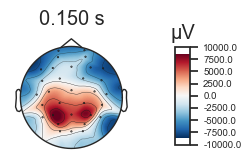

In [39]:
plot_topo_psd(ev_data_hahv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)


/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from yo

AttributeError: 'Colorbar' object has no attribute 'patch'

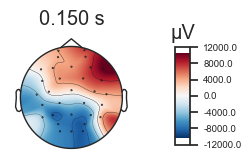

In [40]:
plot_topo_psd(ev_data_halv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)


/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from yo

AttributeError: 'Colorbar' object has no attribute 'patch'

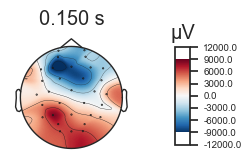

In [41]:
plot_topo_psd(ev_data_lahv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)


/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from yo

AttributeError: 'Colorbar' object has no attribute 'patch'

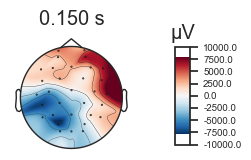

In [42]:
plot_topo_psd(ev_data_lalv)

#### Topomaps of subjects from HAHV - HALV - LAHV - LALV groups by FOOOF

This will help plotting topomaps of all bands with the same scale of power spectra.

In [43]:
# Deal with NaN values when the model cannot detect peaks in any given range
def check_nans(data, nan_policy='zero'):
    """Check an array for nan values, and replace, based on policy."""
    # Find where there are nan values in the data
    nan_inds = np.where(np.isnan(data))
    # Apply desired nan policy to data
    if nan_policy == 'zero':
        data[nan_inds] = 0
    elif nan_policy == 'mean':
        data[nan_inds] = np.nanmean(data)
    else:
        raise ValueError('Nan policy not understood.')
    return data

In [44]:
# Plot the topographies across different frequency bands
def plot_psd_fooof(evData):
  fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, peak_threshold=2., max_n_peaks=6, verbose=False)
  bands = Bands({'theta': [4, 8],'alpha': [8, 12],'beta': [12, 30],'gamma': [30, 64]})
  freq_range = [1, 128]
  # Calculate power spectra across the the continuous data by MNE
  spectra, freqs = psd_welch(evData, fmin=1, fmax=128, tmin=0, tmax=250, n_overlap=150, n_fft=300)
  fg.fit(freqs, spectra, freq_range)
  # Plot the topographies across different frequency bands
  fig, axes = plt.subplots(1, 4, figsize=(20, 5))
  for ind, (label, band_def) in enumerate(bands):
      # Extract the power peaks across channels for the current band
      band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])
      # Create a topomap for the current oscillation band
      mne.viz.plot_topomap(band_power, evData.info, cmap=cm.viridis, axes=axes[ind], show=False);
      axes[ind].set_title(label + ' power', {'fontsize' : 16})

In [45]:
def plot_psd_peak(evData):
  fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, peak_threshold=2., max_n_peaks=6, verbose=False)
  bands = Bands({'theta': [4, 8],'alpha': [8, 12],'beta': [12, 30],'gamma': [30, 64]})
  freq_range = [1, 128]
  # Calculate power spectra across the the continuous data by MNE
  spectra, freqs = psd_welch(evData, fmin=1, fmax=128, tmin=0, tmax=250, n_overlap=150, n_fft=300)
  fg.fit(freqs, spectra, freq_range)
  # Check the largest detected peaks within each band
  fig, axes = plt.subplots(1, 4, figsize=(20, 6))
  for ind, (label, band_def) in enumerate(bands):
      # Get the power values across channels for the current band
      band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])
      # Extracted and plot the power spectrum model with the most band power
      fg.get_fooof(np.argmax(band_power)).plot(ax=axes[ind], add_legend=False)
      axes[ind].yaxis.set_ticklabels([])
      axes[ind].set_title('biggest ' + label + ' peak', {'fontsize' : 16})

Effective window size : 2.344 (s)


/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed t

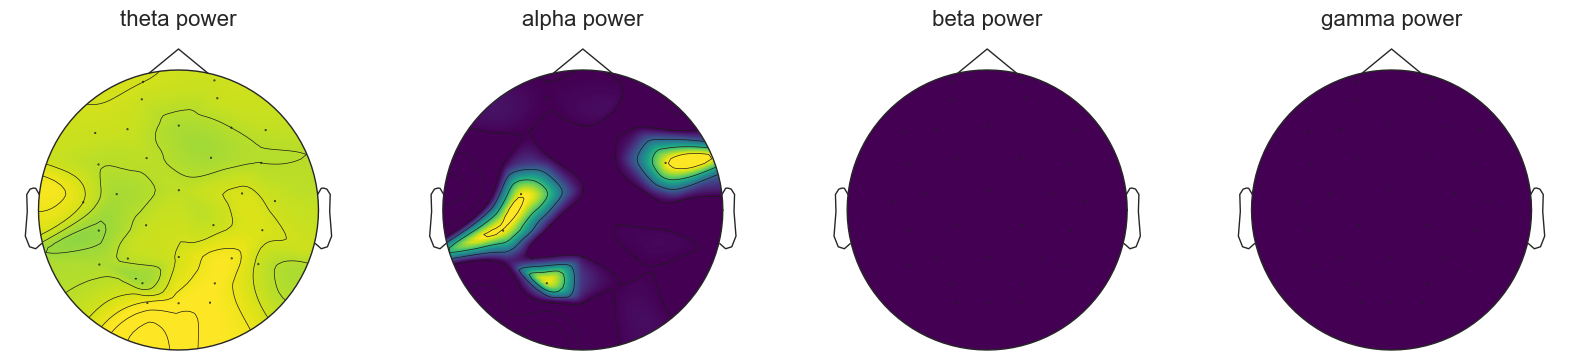

In [46]:
plot_psd_fooof(ev_data_hahv)

Effective window size : 2.344 (s)


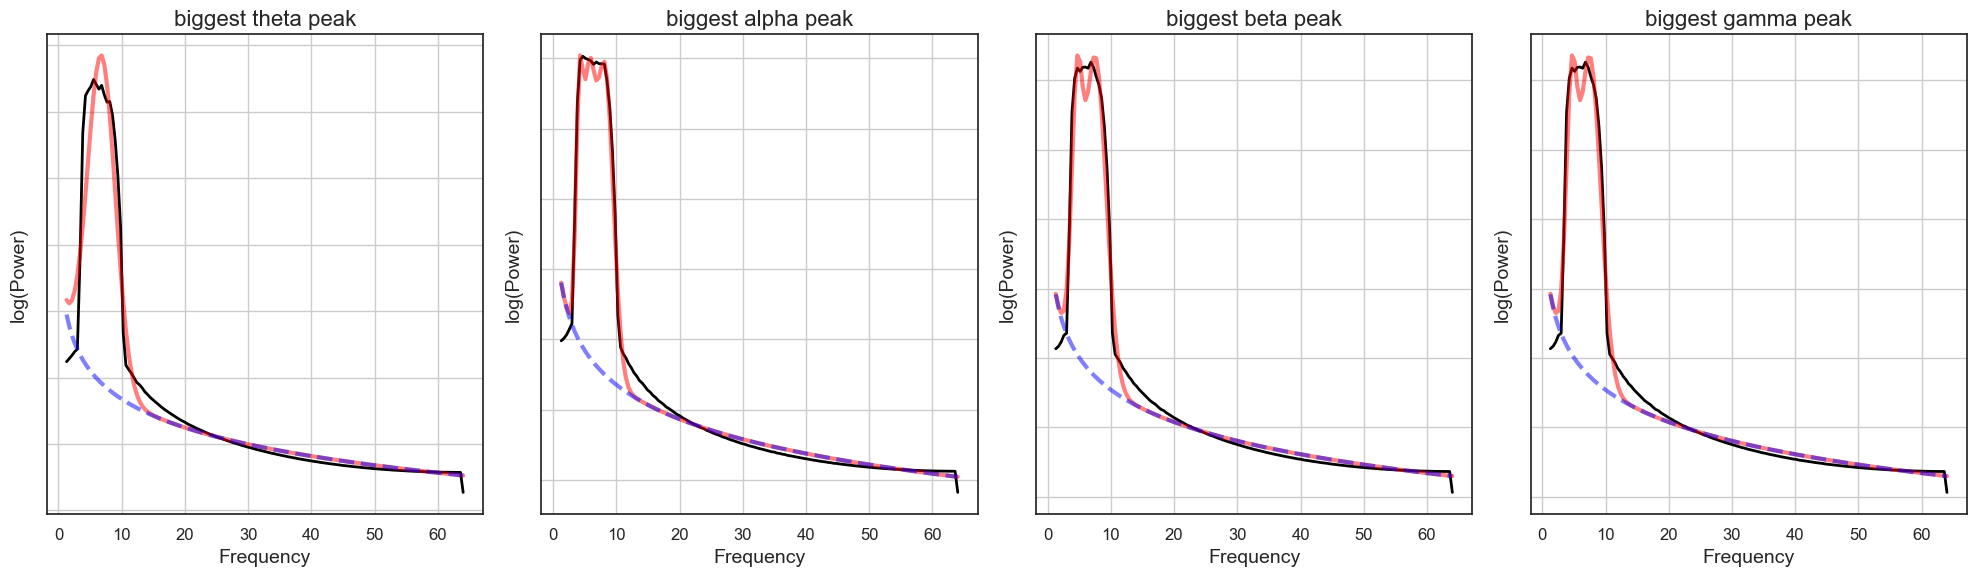

In [47]:
plot_psd_peak(ev_data_hahv)

Effective window size : 2.344 (s)


/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed t

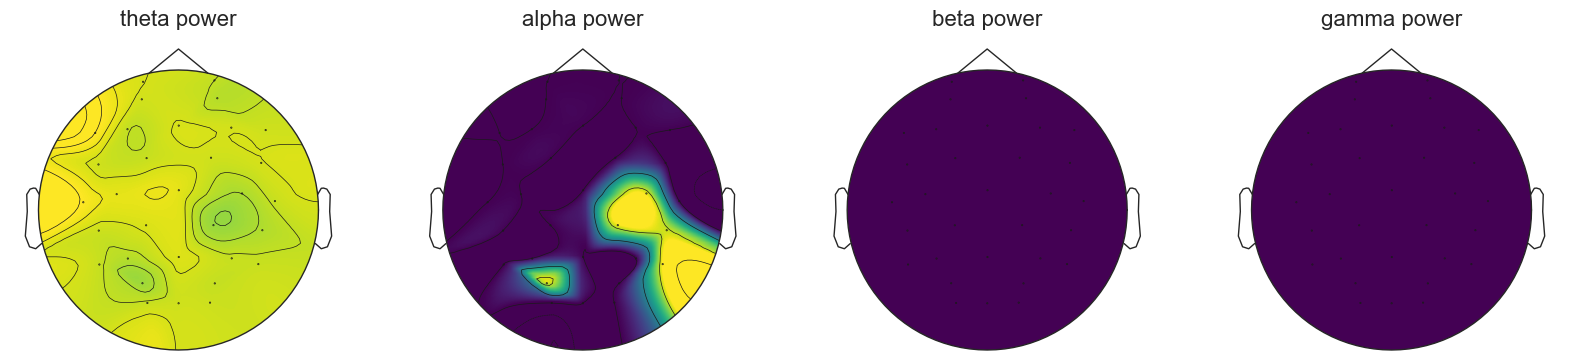

In [48]:
plot_psd_fooof(ev_data_halv)

Effective window size : 2.344 (s)


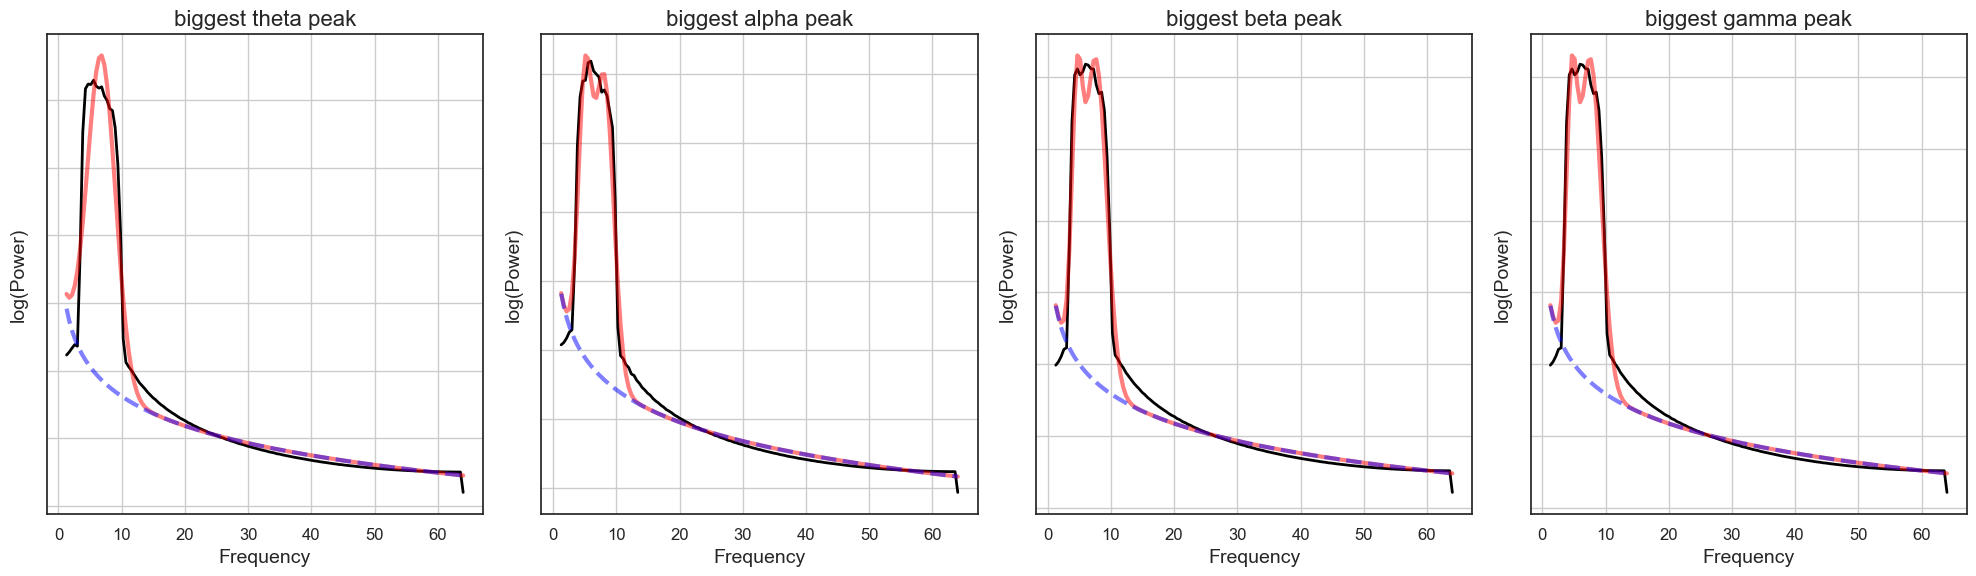

In [49]:
plot_psd_peak(ev_data_halv)

Effective window size : 2.344 (s)


/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed t

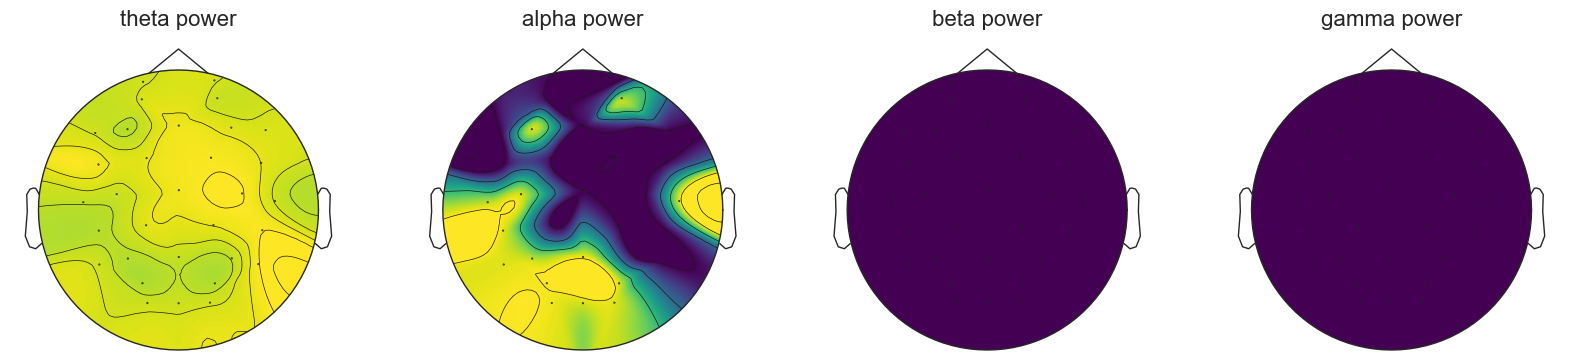

In [50]:
plot_psd_fooof(ev_data_lahv)

Effective window size : 2.344 (s)


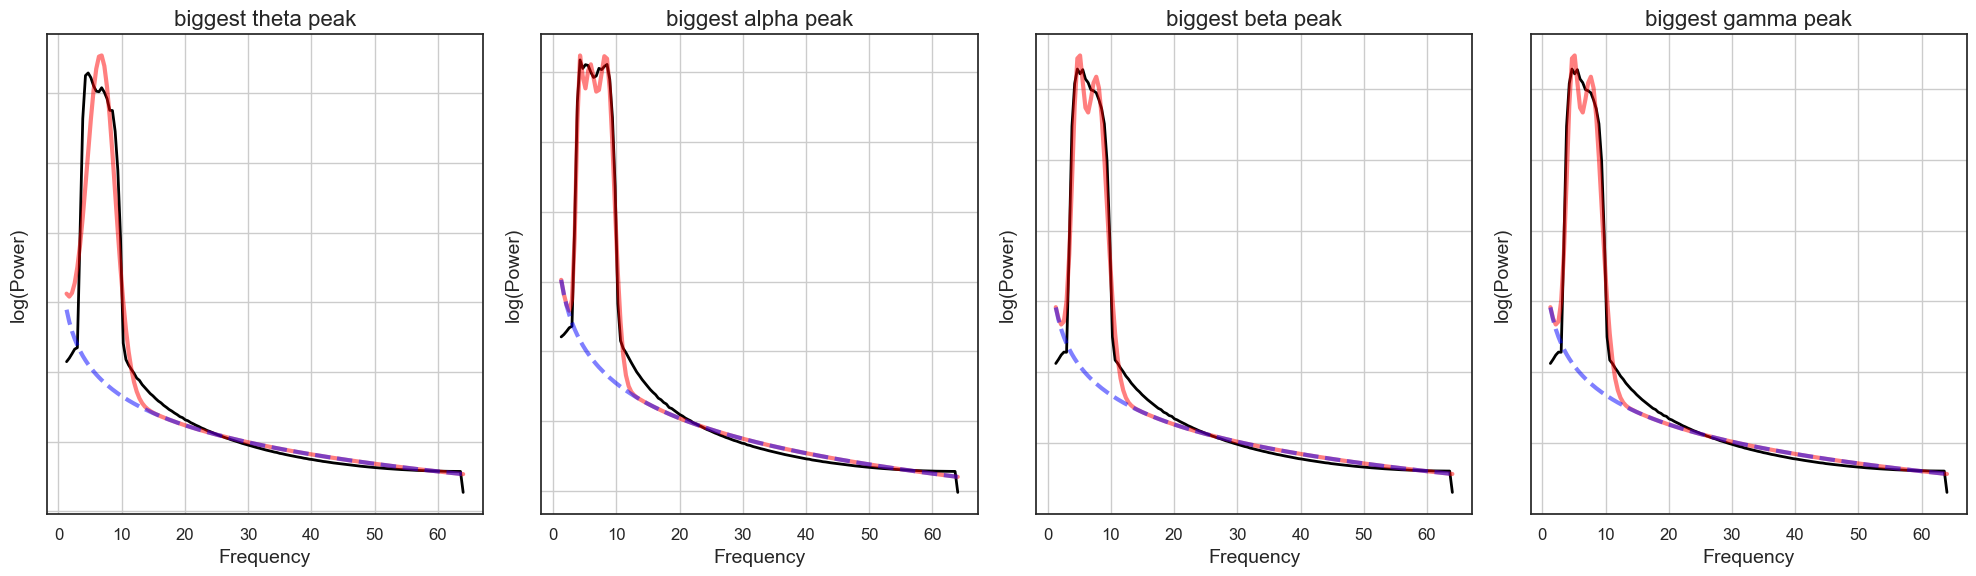

In [51]:
plot_psd_peak(ev_data_lahv)

Effective window size : 2.344 (s)


/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/xiaominghao/anaconda3/envs/deapnew/lib/python3.10/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed t

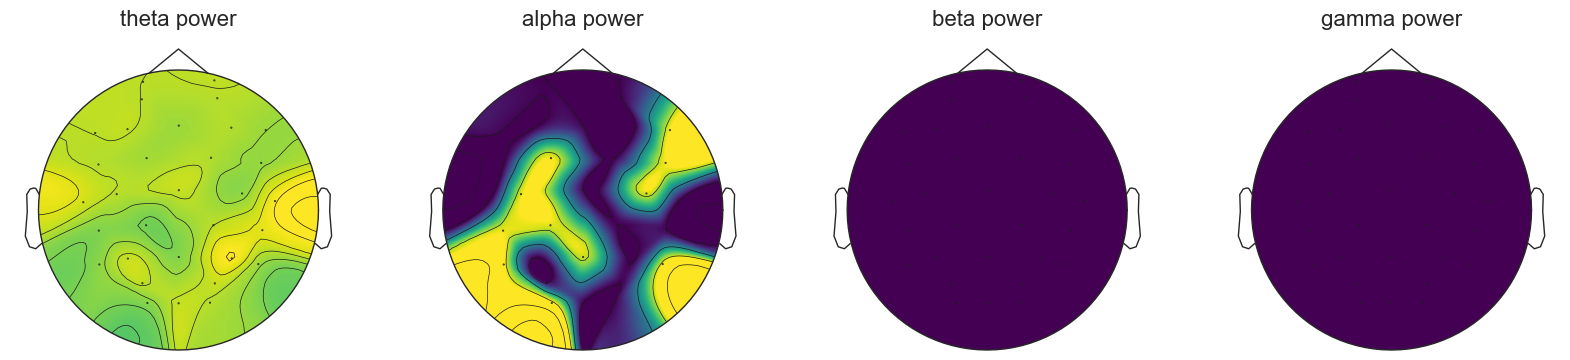

In [52]:
plot_psd_fooof(ev_data_lalv)

Effective window size : 2.344 (s)


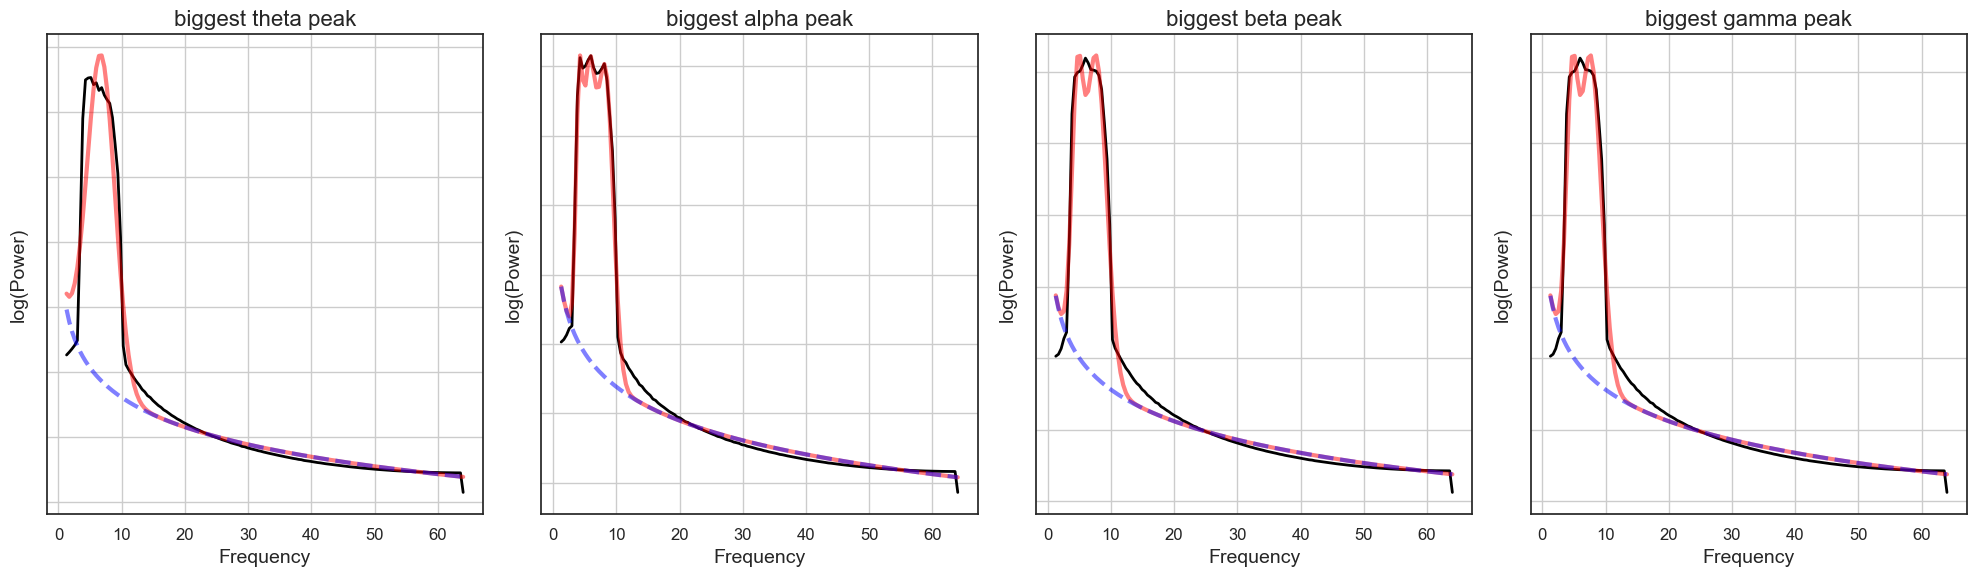

In [53]:
plot_psd_peak(ev_data_lalv)

### Process new datasets with 6 EEG regions and 4 band power values

In [54]:
# Transform 880 x 32 x 8064 => 880 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
eeg_band_arr = np.reshape(eeg_band_arr, (880, 128))

EEG channels are divided into 6 groups, according to their cerebral spatial locations. We combine the temmporal-left and temporal-right channels into the left and right groups. The frontal group only includes the fronto-central channels. All centro-parietal channels are included in the central group.

In [55]:
left = np.array(["Fp1", "AF3", "F7", "FC5", "T7"])
right = np.array(["Fp2", "AF4", "F8", "FC6", "T8"])
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

#### Dataframe for Theta power values

In [56]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (880, 32))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

                Fp1           AF3            F3            F7           FC5  \
count    880.000000    880.000000    880.000000    880.000000    880.000000   
mean     547.698669   1275.382463    961.472903   2081.239112    946.542801   
std     1217.589360   3736.181734   3558.844204   5918.702323   2572.974714   
min        2.698928      3.034321      3.150251      3.633784      1.897310   
25%       24.093211     18.601381     22.046306     39.123277     13.872183   
50%       58.450614     72.755754     73.991298    105.346160     43.000439   
75%      366.274753    313.477898    196.346622    278.757018    256.012013   
max    15524.135098  38122.870846  39431.320394  49272.793208  20182.668545   

               FC1            C3           T7           CP5          CP1  ...  \
count   880.000000    880.000000   880.000000    880.000000   880.000000  ...   
mean    335.659206    629.688479   384.182968    437.471145   278.675374  ...   
std     714.083534   1774.585610   690.042565

In [57]:
# Only print central channels
print(df_theta[central].head(5)) 

        CP5       CP1        Cz        C4        C3       CP6       CP2
0  2.722879  1.597882  2.085303  2.697530  3.247666  1.806959  1.623311
1  3.229423  1.965246  2.452893  3.689678  4.325760  1.909712  1.942158
2  3.711943  1.890259  2.386166  3.942938  4.284358  2.503685  1.974655
3  4.004765  1.883543  7.414694  3.498076  4.171965  2.529543  1.736048
4  1.857737  1.447578  1.993286  1.803010  1.798486  1.496299  1.577524


#### Dataframe for Alpha power values

In [58]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_alpha = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_alpha.append(get_band_power(i,j,"alpha"))
eeg_alpha = np.reshape(eeg_alpha, (880, 32))

df_alpha = pd.DataFrame(data = eeg_alpha, columns=eeg_channels)
print(df_alpha.describe())

               Fp1           AF3            F3            F7          FC5  \
count   880.000000    880.000000    880.000000    880.000000   880.000000   
mean    182.768956    432.997737    341.717466    787.386147   314.729614   
std     397.614619   1257.596832   1216.976070   2308.048700   825.812456   
min       1.414231      1.675955      1.744316      1.762554     1.011529   
25%      14.191465     11.606644     11.980286     20.273524    10.026005   
50%      33.255285     30.578066     34.808317     43.435592    18.695757   
75%     143.122306    113.219878     76.686527     98.532143    80.893786   
max    5627.906982  12380.702125  12764.724842  20843.070851  6575.781434   

               FC1           C3           T7          CP5          CP1  ...  \
count   880.000000   880.000000   880.000000   880.000000   880.000000  ...   
mean    121.272829   217.789212   134.556300   152.662820    97.391786  ...   
std     239.501794   589.221744   212.302211   453.810089   171.00240

In [59]:
# Only print occipital channels
print(df_alpha[occipital].head(5)) 

         O1        Oz        O2       PO3       PO4
0  5.312906  4.764141  5.369596  6.327640  6.189954
1  2.037402  2.195514  2.565861  1.703727  3.038914
2  6.263437  5.958844  8.209320  7.656804  9.179372
3  5.632504  5.341003  6.541218  6.627711  6.922430
4  4.457119  4.057350  5.195625  5.767454  5.225959


#### Dataframe for Beta power values

In [60]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_beta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_beta.append(get_band_power(i,j,"beta"))
eeg_beta = np.reshape(eeg_beta, (880, 32))

df_beta = pd.DataFrame(data = eeg_beta, columns=eeg_channels)
print(df_beta.describe())

               Fp1          AF3           F3            F7          FC5  \
count   880.000000   880.000000   880.000000    880.000000   880.000000   
mean    101.585727   263.922757   235.474557    465.370299   179.773399   
std     198.347308   796.402086   788.377271   1519.030003   458.156825   
min       0.356012     0.416375     0.427944      0.441977     0.254806   
25%      18.086819    11.982996    10.729005     22.091801    11.204561   
50%      34.722505    25.125524    36.282166     38.288488    24.475747   
75%      85.835547   126.899960    60.713457     66.695440    51.443774   
max    3528.485435  5784.160193  5841.475721  14848.700463  3094.687504   

               FC1           C3          T7          CP5          CP1  ...  \
count   880.000000   880.000000  880.000000   880.000000   880.000000  ...   
mean     79.050640   122.383767   88.314992   100.518592    56.101709  ...   
std     143.016526   292.635609   99.031686   300.757830    91.937379  ...   
min       0.

In [61]:
# Only print frontal channels
print(df_beta[frontal].head(5)) 

         F3       FC1        Fz        F4       FC2
0  7.240253  3.715183  6.141210  6.747430  4.908805
1  0.560112  0.313907  0.584303  0.688884  0.516354
2  9.839357  4.390210  7.598063  9.444911  6.377253
3  7.032711  3.946574  6.481246  6.763315  5.341841
4  6.021147  3.145262  5.356596  5.797735  4.608033


#### Dataframe for Gamma power values

In [62]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_gamma = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_gamma.append(get_band_power(i,j,"gamma"))
eeg_gamma = np.reshape(eeg_gamma, (880, 32))

df_gamma = pd.DataFrame(data = eeg_gamma, columns=eeg_channels)
print(df_gamma.describe())

               Fp1          AF3           F3           F7          FC5  \
count   880.000000   880.000000   880.000000   880.000000   880.000000   
mean     64.354871   209.701018   194.601979   159.932199   124.191887   
std     161.218678   771.450828   753.376633   592.833331   406.400686   
min       0.020478     0.023952     0.024657     0.025413     0.014644   
25%       9.012946     5.500269     5.077370    11.192724     5.261965   
50%      20.679781    14.559035    15.403148    18.490352    13.541378   
75%      48.359529    74.742440    38.093791    43.985629    44.548886   
max    3213.255538  6060.539788  5758.756812  6348.177208  3472.515858   

               FC1           C3          T7          CP5          CP1  ...  \
count   880.000000   880.000000  880.000000   880.000000   880.000000  ...   
mean     56.185557    74.566233   53.273436    80.528251    32.722871  ...   
std     141.232731   214.344830   71.250571   292.090716    77.717747  ...   
min       0.013463   

In [63]:
# Only print parietal channels
print(df_gamma[parietal].head(5)) 

         P3        P7        Pz        P4        P8
0  1.348347  2.099580  0.578703  1.583309  1.242910
1  0.037588  0.027263  0.013363  0.048656  0.016915
2  1.405996  2.340776  0.614935  1.759804  1.651851
3  1.127093  1.381447  0.555637  1.406085  0.804002
4  1.031171  1.626731  0.535351  1.275852  1.514359


# Train-test split and feature scaling

In [64]:
# Split the data into training/testing sets
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
  return x_train, x_test, y_train, y_test

In [65]:
# Feature scaling
def feature_scaling(train, test):
  sc = StandardScaler()
  train = sc.fit_transform(train)
  test = sc.transform(test)
  return train, test

# Cross-validation to select classifier

In [66]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["left", "frontal", "right", "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [67]:
# Testing different kernels (linear, sigmoid, rbf, poly) to select the most optimal one
clf_svm = SVC(kernel = 'linear', random_state = 42, probability=True)

In [68]:
# Testing different k (odd) numbers, algorithm (auto, ball_tree, kd_tree) and weight (uniform, distance) to select the most optimal one
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')

In [69]:
# Testing different learning rate (alpha), solver (adam, sgd, lbfgs) and activation (relu, tanh, logistic) to select the most optimal one
clf_mlp = MLPClassifier(solver='adam', activation='tanh', alpha=0.3, max_iter=400)

In [70]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))
models.append(('MLP', clf_mlp))

In [71]:
import time
def cross_validate_clf(df_x, df_y, scoring):
  # Train-test split 
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  # Feature scaling
  x_train, x_test = feature_scaling(x_train, x_test)

  names = []
  means = []
  stds = []
  times = []

  # Apply CV
  for name, model in models:
      start_time = time.time()
      kfold = model_selection.KFold(n_splits=5)
      cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
      t = (time.time() - start_time)
      times.append(t)
      means.append(cv_results.mean())
      stds.append(cv_results.std())
      names.append(name)

  return names, means, stds, times

### Arousal - Accuracy

In [72]:
cross_validate_clf(eeg_band_arr, df_arousal, 'accuracy')

(['SVM', 'k-NN', 'MLP'],
 [0.5827432467873066, 0.5794518751639129, 0.5891948596905324],
 [0.032101393745388146, 0.043908587776586294, 0.03210807798303765],
 [0.4377872943878174, 0.07812190055847168, 3.860255002975464])

### Arousal - F1

In [73]:
cross_validate_clf(eeg_band_arr, df_arousal, 'f1')

(['SVM', 'k-NN', 'MLP'],
 [0.5923983423983423, 0.5863921656265448, 0.5891344797975684],
 [0.06319728282075993, 0.04922852716049436, 0.05350065700374734],
 [0.48899197578430176, 0.01951003074645996, 3.8972530364990234])

### Valence - Accuracy

In [74]:
cross_validate_clf(eeg_band_arr, df_valence, 'accuracy')

(['SVM', 'k-NN', 'MLP'],
 [0.5780881195908733, 0.6201416207710465, 0.6251245738263834],
 [0.055211667742540715, 0.05167443384421941, 0.0568072872883771],
 [0.5643179416656494, 0.013828277587890625, 4.579753160476685])

### Valence - F1

In [75]:
cross_validate_clf(eeg_band_arr, df_valence, 'f1')

(['SVM', 'k-NN', 'MLP'],
 [0.568831883151483, 0.6313018560839601, 0.626659128530832],
 [0.054174021396036345, 0.06465345580673694, 0.0909536986762503],
 [0.561427116394043, 0.01700592041015625, 3.928943157196045])

# Apply classifier

## Functions to run classifiers

In [76]:
def run_clf_cv(band, channel, label, clf):
  if band == "theta":
    df_x = df_theta
  elif band == "alpha":
    df_x = df_alpha
  elif band == "beta":
    df_x = df_beta
  elif band == "gamma":
    df_x = df_gamma

  if channel == "left":
    df_x = df_x[left]
  elif channel == "right":
    df_x = df_x[right]
  elif channel == "frontal":
    df_x = df_x[frontal]
  elif channel == "central":
    df_x = df_x[central]
  elif channel == "parietal":
    df_x = df_x[parietal]
  elif channel == "occipital":
    df_x = df_x[occipital]

  df_y = df_arousal if (label == "arousal") else df_valence

  # Train-test split
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  
  # Apply CV
  x_for_kfold = np.array(x_train)            
  y_for_kfold = np.array(y_train)
  kfold = model_selection.KFold(n_splits=5)

  for i, j in kfold.split(x_for_kfold):
   x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
   y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]
  
  # Feature scaling
  x_train2, x_test2 = feature_scaling(x_train2, x_test2)

  if clf == "svm":
    clf_svm.fit(x_train2, y_train2)
    y_predict = clf_svm.predict(x_test2)
  elif clf == "knn":
    clf_knn.fit(x_train2, y_train2)
    y_predict = clf_knn.predict(x_test2)
  elif clf == "mlp":
    clf_mlp.fit(x_train2, y_train2)
    y_predict = clf_mlp.predict(x_test2)

  return y_test2, y_predict

In [77]:
def get_accuracy(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(accuracy_score(y_test2, y_predict)*100,2)

In [78]:
def print_accuracy(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_accuracy(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG region")
  print(df.idxmax())
  print()
  print(df)

In [79]:
def get_f1(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(f1_score(y_test2, y_predict)*100,2)

In [80]:
def print_f1(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_f1(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG regions")
  print(df.idxmax())
  print()
  print(df)

In [81]:
def plot_cm(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  cm = confusion_matrix(y_test2, y_predict)
  print(cm)
  cr = classification_report(y_test2, y_predict)
  print(cr)

  plt.figure()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()

  if (label == "valence"):
    classes = df_valence.unique().tolist()
  if (label == "arousal"):
    classes = df_arousal.unique().tolist()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


## Accuracy results

### Valence

In [82]:
# Only use k-NN in case of Valence after CV
print_accuracy('valence', 'knn')

Top 3 EEG regions with highest scores
right      70.73
left       69.11
central    66.67
dtype: float64

Top 2 bands with highest scores
gamma    70.73
beta     69.11
dtype: float64

EEG region with highest scores per each band
theta    central
alpha    central
beta        left
gamma      right
dtype: object

Band with highest scores per each EEG region
left          beta
frontal       beta
right        gamma
central      theta
parietal      beta
occipital     beta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  57.72    63.41  57.72    66.67     56.91      55.28
alpha  58.54    51.22  60.98    66.67     63.41      55.28
beta   69.11    65.04  66.67    59.35     65.85      64.23
gamma  59.35    61.79  70.73    61.79     60.16      62.60


### Arousal

In [83]:
# Only use MLP in case of Arousal after CV
print_accuracy('arousal', 'mlp')

Top 3 EEG regions with highest scores
left        61.79
parietal    60.98
central     59.35
dtype: float64

Top 2 bands with highest scores
gamma    61.79
beta     60.98
dtype: float64

EEG region with highest scores per each band
theta    parietal
alpha     central
beta     parietal
gamma        left
dtype: object

Band with highest scores per each EEG region
left         gamma
frontal      theta
right        theta
central      theta
parietal      beta
occipital    theta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  53.66    54.47  52.03    59.35     60.16      55.28
alpha  52.85    53.66  52.03    57.72     57.72      51.22
beta   52.85    51.22  47.97    52.03     60.98      47.15
gamma  61.79    48.78  43.90    52.03     60.16      44.72


## F1 score results

### Valence

In [84]:
# Only use k-NN in case of Valence after CV
print_f1('valence', 'knn')

Top 3 EEG regions with highest scores
right      74.65
central    70.92
left       69.35
dtype: float64

Top 2 bands with highest scores
gamma    74.65
beta     71.72
dtype: float64

EEG region with highest scores per each band
theta    central
alpha    central
beta       right
gamma      right
dtype: object

Band with highest scores per each EEG regions
left          beta
frontal       beta
right        gamma
central      theta
parietal      beta
occipital     beta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  60.61    68.53  62.32    70.92     60.74      59.26
alpha  61.07    53.12  64.71    70.07     66.17      58.65
beta   69.35    68.61  71.72    62.12     68.18      68.57
gamma  61.54    64.66  74.65    66.19     64.23      68.49


### Arousal

In [85]:
# Only use MLP in case of Arousal after CV
print_f1('arousal', 'mlp')

Top 3 EEG regions with highest scores
parietal     66.67
central      65.77
occipital    65.48
dtype: float64

Top 2 bands with highest scores
theta    66.67
alpha    65.77
dtype: float64

EEG region with highest scores per each band
theta    parietal
alpha     central
beta      central
gamma       right
dtype: object

Band with highest scores per each EEG regions
left         theta
frontal      theta
right        theta
central      alpha
parietal     theta
occipital    theta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  63.69    61.43  63.80    65.33     66.67      65.48
alpha  62.89    59.42  63.35    65.77     58.46      63.86
beta   52.10    54.55  59.49    60.27     55.65      57.32
gamma  56.36    54.68  57.69    57.14     53.70      38.46


## Plot results

#### Top combinations for Valence

[[32 21]
 [20 50]]
              precision    recall  f1-score   support

           0       0.62      0.60      0.61        53
           1       0.70      0.71      0.71        70

    accuracy                           0.67       123
   macro avg       0.66      0.66      0.66       123
weighted avg       0.67      0.67      0.67       123


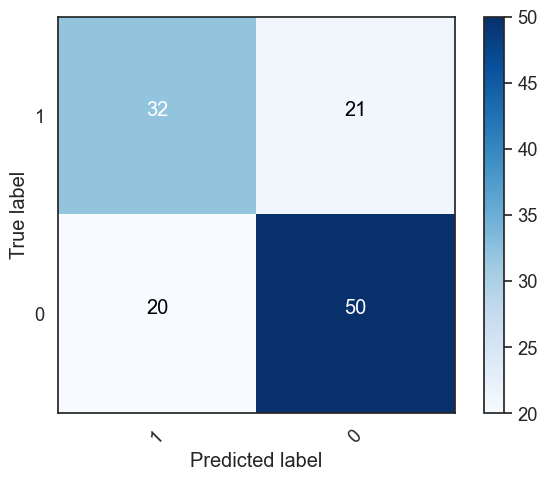

In [86]:
plot_cm('theta', 'central', 'valence', 'knn')

[[42 11]
 [27 43]]
              precision    recall  f1-score   support

           0       0.61      0.79      0.69        53
           1       0.80      0.61      0.69        70

    accuracy                           0.69       123
   macro avg       0.70      0.70      0.69       123
weighted avg       0.72      0.69      0.69       123


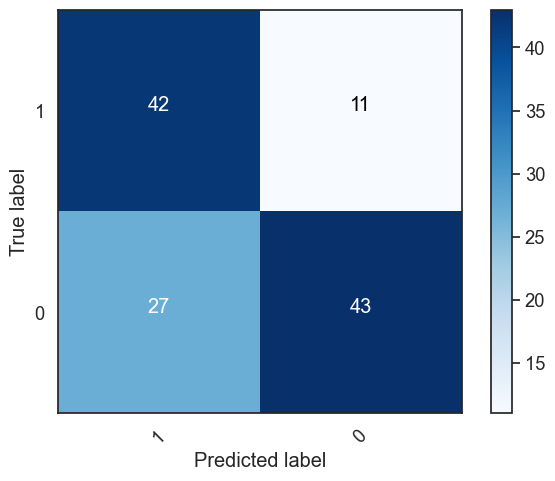

In [87]:
plot_cm('beta', 'left', 'valence', 'knn')

[[34 19]
 [17 53]]
              precision    recall  f1-score   support

           0       0.67      0.64      0.65        53
           1       0.74      0.76      0.75        70

    accuracy                           0.71       123
   macro avg       0.70      0.70      0.70       123
weighted avg       0.71      0.71      0.71       123


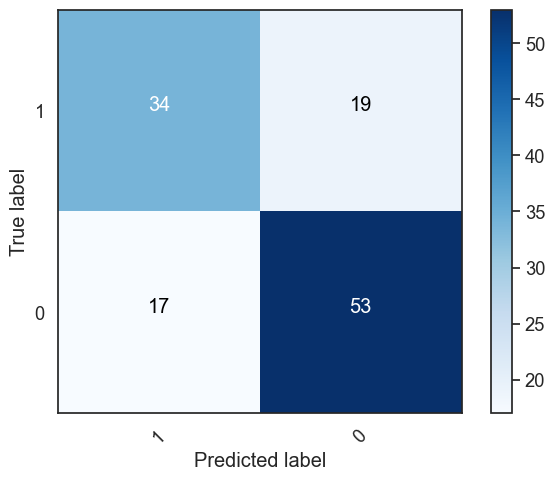

In [88]:
plot_cm('gamma', 'right', 'valence', 'knn')

#### Top combinations for Arousal

[[17 44]
 [11 51]]
              precision    recall  f1-score   support

           0       0.61      0.28      0.38        61
           1       0.54      0.82      0.65        62

    accuracy                           0.55       123
   macro avg       0.57      0.55      0.52       123
weighted avg       0.57      0.55      0.52       123


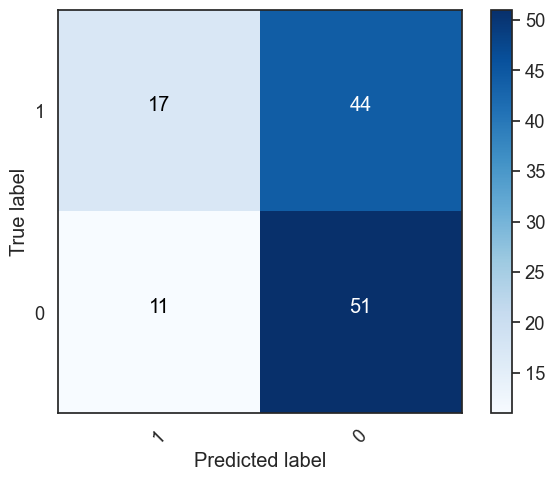

In [89]:
plot_cm('alpha', 'central', 'arousal', 'mlp')

[[27 34]
 [14 48]]
              precision    recall  f1-score   support

           0       0.66      0.44      0.53        61
           1       0.59      0.77      0.67        62

    accuracy                           0.61       123
   macro avg       0.62      0.61      0.60       123
weighted avg       0.62      0.61      0.60       123


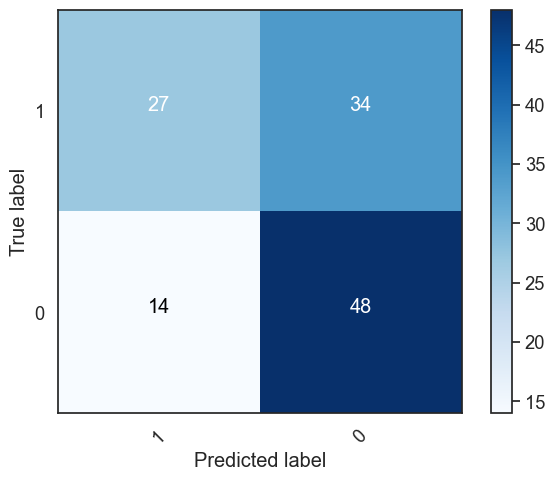

In [90]:
plot_cm('theta', 'parietal', 'arousal', 'mlp')

[[19 42]
 [16 46]]
              precision    recall  f1-score   support

           0       0.54      0.31      0.40        61
           1       0.52      0.74      0.61        62

    accuracy                           0.53       123
   macro avg       0.53      0.53      0.50       123
weighted avg       0.53      0.53      0.51       123


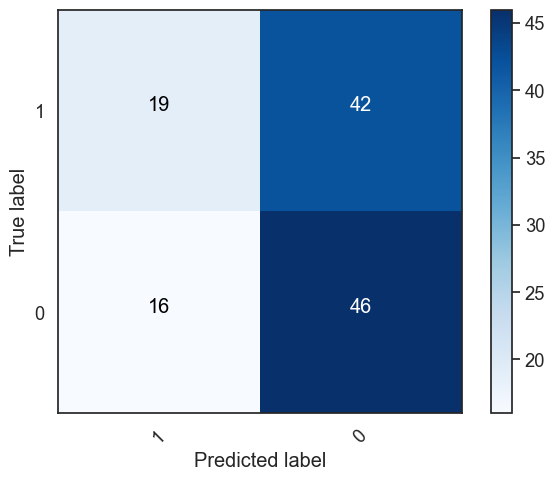

In [91]:
plot_cm('beta', 'frontal', 'arousal', 'mlp')